# Week 13: Poly Square Mapping as a whole
Consider both boundary classification & distortion

## Table of Contents
- [0 - Packages](#0)
- [1 - Test Example](#1)
- [2 - The Loss Function](#2)
- [3 - Result](#3)
- [4 - Intuition of Angle Activation](#4)
- [5 - Problems](#5)
- [6 - Reference](#6)

<a name='0'></a>
## 0 - Package

In [132]:
# Packages
import numpy as np
import matplotlib.pyplot as plt

# Self-defined functions
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))
from util.mesh.triangle.algorithm.R2.mapping_poly_square import Chen_2023_scipy

from util.pyvista_util import preprocess, postprocess

tritess_v, tritess_f = preprocess("./mesh/cat/cat_input.ply")
tritess_test = Chen_2023_scipy(tritess_v, tritess_f)
tritess_test.optimize_default()
tritess_test.mapping()
postprocess("./mesh/cat/cat_output2.ply", tritess_test.solution, tritess_f)

<a name='1'></a>
## 1 - Test Example

In [143]:
test.vertices == test_torch.vertices

array([[False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False]])

In [190]:
class Chen_2023_pytorch:
    def __init__(self, vertices, faces, lambda1=1, lambda2=1, max_iter = 100, learning_rate=0.001):
        self.max_iter = max_iter
        self.v_num = vertices.shape[0]
        self.vertices = vertices
        self.solution = self.vertices.copy()
        self.faces = faces
        self.J = []
        self.b = []
        self.loss = float('inf')
        
        # Hyper parameters
        self.lambda1=lambda1
        self.lambda2=lambda2
        self.lr = learning_rate
        
        # Assuming that retrieve_boundary_* functions are available and compatible with PyTorch
        self.BE_r_V = retrieve_boundary_edges(faces)
        self.BV_r_V = retrieve_boundary_vertices(faces)
        self.BV_r_BV = retrieve_adjacent_vertices_with_boundary_vertex(self.BV_r_V, self.BE_r_V)
        self.BE_r_BV = retrieve_boundary_edges_related_vertices_2D(self.BV_r_V, self.BE_r_V)
        self.BV_num = len(self.BV_r_V)
        self.BV = torch.tensor(self.solution[self.BV_r_V], requires_grad=True, dtype=torch.float64
#                                , device='cuda'
                              )
        
    
    def activation(self, angle):
        if angle < (torch.pi/2):
            return torch.pow(torch.cos(angle), 2) / angle
        else:
            return torch.pow(torch.sin(2*angle), 2)
        
    def objective(self, BV):
        E_align = 0
        E_angle = 0
        
        for i, (v1, v2) in enumerate(self.BV_r_BV):
            edge1 = BV[v1] - BV[i]
            edge2 = BV[v2] - BV[i]
            
            L1 = torch.norm(edge1)
            L2 = torch.norm(edge2)
            
            cos_theta = torch.dot(edge1, edge2) / (L1 * L2)
            angle = torch.acos(torch.clamp(cos_theta, -1.0, 1.0))
            
            E_angle += self.activation(angle)
            E_align += L1 * (torch.sum(torch.abs(edge1 / L1)) - 1) + L2 * (torch.sum(torch.abs(edge2 / L2)) - 1)

        return E_angle + E_align
    
    # Assuming that Tutte_embedding_2D function is available and compatible with PyTorch
    def mapping(self):
        self.solution = Tutte_embedding_2D(vertices, faces, self.solution[self.BV_r_V])
        
        for face in self.faces:
            A, B, C = self.solution[face]
            A_, B_, C_ = self.vertices[face]
            
            before = np.column_stack([B_-A_,C_-A_])
            after = np.column_stack([B-A,C-A])
            J_ = after @ np.linalg.inv(before)
            b_ = J_ @ B_ - B
            self.J.append(J_)
            self.b.append(b_)
            
    def optimize(self, lr=0.003, num_iter=100, tolerance=1e-1, loss_max=1):
        self.lr=lr
        self.max_iter=num_iter
        self.optimizer = LBFGS([self.BV], lr=self.lr)
        
        for i in range(num_iter):  
            loss = self.optimizer.step(self.closure)
            print(loss.item())
            if(self.loss - loss.item() < tolerance) or self.loss < loss_max:
                break
            self.loss = loss.item()

        self.solution[self.BV_r_V]=self.BV.detach().numpy()
        
    def closure(self):
        self.optimizer.zero_grad()
        loss = self.objective(self.BV)
        if(loss.item() > self.loss):
            return loss
        loss.backward()
        return loss

    def v_plt(self, show_origin=False, show_BV=False, show_vertices=False, show_inner_edges=False, save_dict='', show_boundary_v=False):
#         self.solution[self.BV_r_V] = self.BV
        if show_inner_edges:
            plt.triplot(self.solution[:,0], self.solution[:,1], self.faces, color='skyblue')
        if show_vertices:
            plt.plot(self.vertices[:,0], self.vertices[:,1], 'o')
        if show_BV:
            BV = self.BV.detach().numpy()
            plt.plot(BV[:,0], BV[:,1], 'o', color="green")
        if show_origin:
            for edge in self.BE_r_V:
                plt.plot(self.vertices[np.array(edge), 0], self.vertices[np.array(edge), 1], 'g-')
            plt.plot(self.vertices[np.array(self.BE_r_V[0]), 0], self.vertices[np.array(self.BE_r_V[0]), 1],label='Boundary before mapping', color='green')
            if show_inner_edges:
                plt.triplot(self.vertices[:,0], self.vertices[:,1], self.faces, color='greenyellow')
        for edge in self.BE_r_V:
            plt.plot(self.solution[np.array(edge), 0], self.solution[np.array(edge), 1], 'b-')
        plt.plot(self.solution[np.array(self.BE_r_V[0]), 0], self.solution[np.array(self.BE_r_V[0]), 1], label='Boundary after mapping', color='blue')
        if show_boundary_v:
            plt.plot(self.solution[self.BV_r_V,0], self.solution[self.BV_r_V,1], 'o')
        plt.axis('equal')
        plt.legend()
        if save_dict:
            plt.savefig(save_dict, dpi=300)
        plt.show()

In [191]:
test_torch = Chen_2023_pytorch(vertices.copy(), faces.copy())

In [192]:
test_torch.optimize(
    lr=0.01, 
    tolerance=0.001)

19.046441407623167
15.330476793967163
15.25776330094423
15.180818527223925
15.098635243929781
15.009922184520995
14.913011116523458
14.805736647401922
14.685287840152103
14.548041763748884
14.389415618818017
14.24936687017189
14.235537079498123
14.221641555248556
14.20768012564788
14.193652621803928
14.1795588777553
14.165398730518863
14.151172020137404
14.136878589727246
14.12251828552585
14.108090956939522
14.093596456591026
14.079034640367187
14.064405367466595
14.049708500447132
14.034943905273531
14.020111451364903
14.005211011642235
13.990242462575797
13.975205684232517
13.960100560323255
13.944926978250066
13.929684829153228
13.914374007958436
13.898994413423647
13.883545948186036
13.868028518808579
13.852442035826865
13.836786413795476
13.8210615713344
13.805267431175295
13.789403920207597
13.77347096952445
13.75746851446853
13.741396494677709
13.725254854130513
13.709043541191393
13.692762508655926
13.676411713795794
13.659991118403433
13.643500688836745
13.626940396063352
13.

In [193]:
test_torch.mapping()

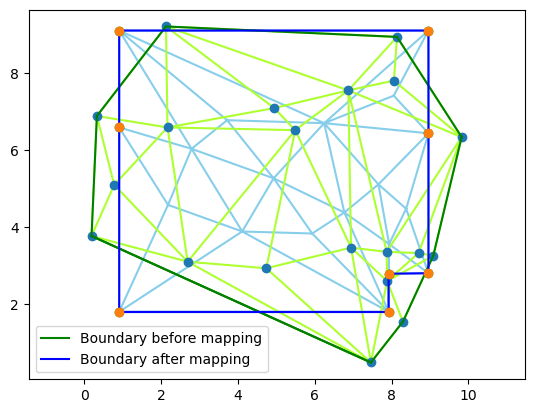

In [194]:
test_torch.v_plt(show_origin=True, show_inner_edges=True, show_vertices=True, show_boundary_v=True, show_BV=True)

# ------------------------------------------------------------------------------------------

In [326]:
import torch
from torch.optim import LBFGS

# 定义我们想要最小化的函数
def func(x):
    return (x - 2)**2

# 初始值 x0
x = torch.tensor([0.0], requires_grad=True)

# 使用L-BFGS优化器
optimizer = LBFGS([x], lr=0.01)

def closure():
    optimizer.zero_grad()
    output = func(x)
    output.backward()
    return output

In [129]:
# 迭代优化
for step in range(20):
    optimizer.step(closure)

print(f"Optimized value of x: {x.item()}")

Optimized value of x: 1.96391761302948
